In [122]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.datasets import Datasets, MapDataset
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
    PowerLawNormSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
)


# %matplotlib inline
import numpy as np
from gammapy.maps import Map, MapAxis, MapAxes, WcsGeom

# HESS GPS Sources

In [2]:
from gammapy.catalog import SourceCatalogHGPS


hess_catalog = SourceCatalogHGPS("hgps_catalog_v1.fits.gz")

hess_models = hess_catalog.to_models()

print(f"\nThere are {len(hess_models)} sources within the HGPS.")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources within the HGPS.


In [404]:
energy_min = 0.1
energy_max = 100

energy_axis_true = MapAxis.from_energy_bounds(
    energy_min*u.TeV , energy_max*u.TeV, nbin=int(round(50*(np.log10(energy_max)-np.log10(energy_min)))), name="energy_true"
)
goodgeom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 10),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis_true],
)

goodmap = Map.from_geom(goodgeom)
goodmap

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (500, 500, 150)
	ndim  : 3
	unit  : 
	dtype : float32

In [494]:
# fig, ax = plt.subplots(2,4, figsize=(8,3))


# m = Map.create(skydir=(0, 0), width=(10, 10), binsz=0.1, frame="galactic")
m= goodmap
count=0
fullhessdataset = 0
for idx, model in enumerate(hess_models):
    templvalue = model.spatial_model.position.l.value
    tempbvalue = model.spatial_model.position.b.value
    
    if templvalue>180:
        templvalue=templvalue-360
    
    if np.abs(templvalue)<5 and np.abs(tempbvalue)<5:
        print(templvalue, tempbvalue, idx)
        try:
            m.quantity = model.evaluate_geom(m.geom)
            # m.plot(ax=ax[count//4, count%4], add_cbar=True)
            startdata = m.data
            data = startdata[~np.isnan(startdata)]
            if data.size!=0:
                data = data.reshape(startdata.shape)
                fullhessdataset+=data
            
        except:
            print("Something weird happened")
            print(idx, '\n\n')
        count+=1
# plt.show()

-1.723175048828125 0.04908088967204094 46
-0.05511474609375 -0.043911051005125046 47
-1.35516357421875 -0.5642170310020447 48
0.14000000059604645 -0.11400000005960464 49
-1.551788330078125 -1.1144022941589355 50
3.779721736907959 1.714707851409912 51
0.871999979019165 0.07599999755620956 52


In [495]:
150*500*500/250000

150.0

In [496]:
hessgeom = goodmap.geom
hesslonvals = hessgeom.get_coord().lon.value[0][0]
hesslonvals = hesslonvals[::-1]
hesslonvals[hesslonvals>180] = hesslonvals[hesslonvals>180]-360
# print("lon vals", hesslonvals)

hesslatvals = hessgeom.get_coord().lat.value[0][:,0]
# print("lat vals", hesslatvals)
hesslonvals.shape

(500,)

In [497]:
m.quantity.unit

Unit("1 / (cm2 s sr TeV)")

In [499]:
fullhessdataset[0,0,0]

0.0

(500,) (500,) (500, 500)


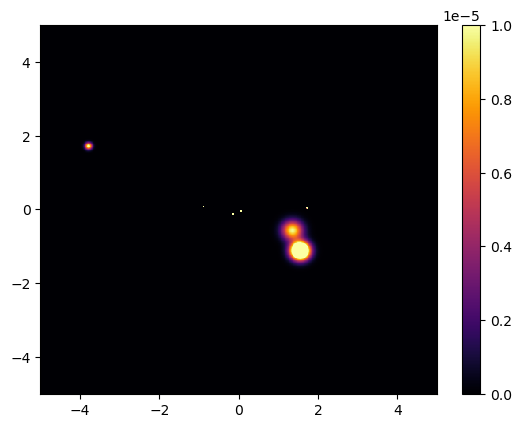

In [500]:
from scipy.ndimage import gaussian_filter

blurred_hess_data = fullhessdataset
print(hesslonvals.shape, hesslatvals.shape, blurred_hess_data[0].shape)
# Factor of 1e6 is so it matches with fermi backgrounds which are 1/MeV
plt.pcolormesh(hesslonvals, 
               hesslatvals, 
               np.max(blurred_hess_data, axis=0), cmap='inferno', vmax=1e-5)
plt.colorbar()
plt.show()

# Fermi-LAT Diffuse Background Extraction

In [501]:
template_diffuse = TemplateSpatialModel.read(
    filename="gll_iem_v06_gc.fits.gz", normalize=False
)

print(template_diffuse.map)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (120, 64, 30)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



In [502]:
fermievaluated = diffuse_iem.evaluate_geom(goodgeom)
fermievaluated.shape

(150, 500, 500)

In [505]:
fermievaluated = fermievaluated.to(1/u.TeV/u.s/u.sr/(u.cm)**2)

In [506]:
fermievaluated[0,0,0]

<Quantity 0. 1 / (cm2 s sr TeV)>

In [507]:
fermilonaxistemp = np.unique(goodgeom.to_image().get_coord().lon.value)
firstover180idx = np.where(fermilonaxistemp>180)[0][0]
fermilonaxistemp[fermilonaxistemp>180] = fermilonaxistemp[fermilonaxistemp>180]-360
fermilonaxistemp.sort()
fermilonaxistemp.shape
fermilonaxis = fermilonaxistemp
fermilonaxis

array([-4.99, -4.97, -4.95, -4.93, -4.91, -4.89, -4.87, -4.85, -4.83,
       -4.81, -4.79, -4.77, -4.75, -4.73, -4.71, -4.69, -4.67, -4.65,
       -4.63, -4.61, -4.59, -4.57, -4.55, -4.53, -4.51, -4.49, -4.47,
       -4.45, -4.43, -4.41, -4.39, -4.37, -4.35, -4.33, -4.31, -4.29,
       -4.27, -4.25, -4.23, -4.21, -4.19, -4.17, -4.15, -4.13, -4.11,
       -4.09, -4.07, -4.05, -4.03, -4.01, -3.99, -3.97, -3.95, -3.93,
       -3.91, -3.89, -3.87, -3.85, -3.83, -3.81, -3.79, -3.77, -3.75,
       -3.73, -3.71, -3.69, -3.67, -3.65, -3.63, -3.61, -3.59, -3.57,
       -3.55, -3.53, -3.51, -3.49, -3.47, -3.45, -3.43, -3.41, -3.39,
       -3.37, -3.35, -3.33, -3.31, -3.29, -3.27, -3.25, -3.23, -3.21,
       -3.19, -3.17, -3.15, -3.13, -3.11, -3.09, -3.07, -3.05, -3.03,
       -3.01, -2.99, -2.97, -2.95, -2.93, -2.91, -2.89, -2.87, -2.85,
       -2.83, -2.81, -2.79, -2.77, -2.75, -2.73, -2.71, -2.69, -2.67,
       -2.65, -2.63, -2.61, -2.59, -2.57, -2.55, -2.53, -2.51, -2.49,
       -2.47, -2.45,

In [462]:
fermilataxis = goodgeom.get_coord().lat.value[0][:,0]
fermilataxis

array([-4.99, -4.97, -4.95, -4.93, -4.91, -4.89, -4.87, -4.85, -4.83,
       -4.81, -4.79, -4.77, -4.75, -4.73, -4.71, -4.69, -4.67, -4.65,
       -4.63, -4.61, -4.59, -4.57, -4.55, -4.53, -4.51, -4.49, -4.47,
       -4.45, -4.43, -4.41, -4.39, -4.37, -4.35, -4.33, -4.31, -4.29,
       -4.27, -4.25, -4.23, -4.21, -4.19, -4.17, -4.15, -4.13, -4.11,
       -4.09, -4.07, -4.05, -4.03, -4.01, -3.99, -3.97, -3.95, -3.93,
       -3.91, -3.89, -3.87, -3.85, -3.83, -3.81, -3.79, -3.77, -3.75,
       -3.73, -3.71, -3.69, -3.67, -3.65, -3.63, -3.61, -3.59, -3.57,
       -3.55, -3.53, -3.51, -3.49, -3.47, -3.45, -3.43, -3.41, -3.39,
       -3.37, -3.35, -3.33, -3.31, -3.29, -3.27, -3.25, -3.23, -3.21,
       -3.19, -3.17, -3.15, -3.13, -3.11, -3.09, -3.07, -3.05, -3.03,
       -3.01, -2.99, -2.97, -2.95, -2.93, -2.91, -2.89, -2.87, -2.85,
       -2.83, -2.81, -2.79, -2.77, -2.75, -2.73, -2.71, -2.69, -2.67,
       -2.65, -2.63, -2.61, -2.59, -2.57, -2.55, -2.53, -2.51, -2.49,
       -2.47, -2.45,

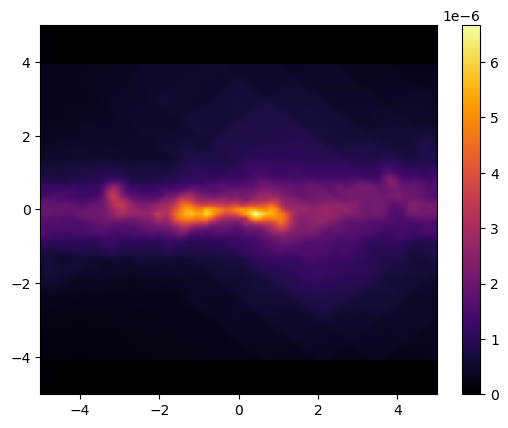

In [508]:
fig, ax = plt.subplots(1,1)
plt.pcolormesh(fermilonaxis, fermilataxis, fermievaluated[0], cmap='inferno')
plt.colorbar()
plt.show()

In [511]:
fermiunit = fermievaluated.unit
fermiunit

Unit("1 / (cm2 s sr TeV)")

In [465]:
fermienergyvals = energy_axis_true.center.value
fermienergyvals

array([ 0.1023293 ,  0.10715193,  0.11220185,  0.11748976,  0.12302688,
        0.12882496,  0.13489629,  0.14125375,  0.14791084,  0.15488166,
        0.16218101,  0.16982437,  0.17782794,  0.18620871,  0.19498446,
        0.20417379,  0.21379621,  0.22387211,  0.23442288,  0.24547089,
        0.25703958,  0.26915348,  0.28183829,  0.29512092,  0.30902954,
        0.32359366,  0.33884416,  0.35481339,  0.37153523,  0.38904514,
        0.40738028,  0.42657952,  0.44668359,  0.46773514,  0.48977882,
        0.51286138,  0.5370318 ,  0.56234133,  0.58884366,  0.616595  ,
        0.64565423,  0.67608298,  0.70794578,  0.74131024,  0.77624712,
        0.81283052,  0.85113804,  0.89125094,  0.9332543 ,  0.97723722,
        1.02329299,  1.07151931,  1.12201845,  1.17489755,  1.23026877,
        1.28824955,  1.34896288,  1.41253754,  1.47910839,  1.54881662,
        1.6218101 ,  1.69824365,  1.77827941,  1.86208714,  1.9498446 ,
        2.04173794,  2.13796209,  2.23872114,  2.34422882,  2.45

In [516]:
fermievaluated[0,0,0]

<Quantity 0. 1 / (cm2 s sr TeV)>

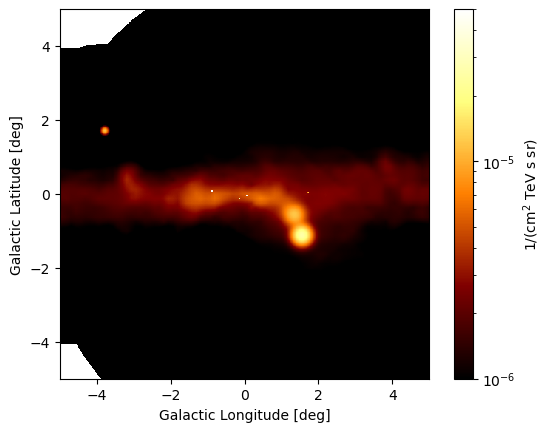

In [536]:
from matplotlib.colors import LogNorm


fermiplotmap = fermievaluated.value
combinedplotmap = fermiplotmap + fullhessdataset



fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0), cmap='afmhot', norm=LogNorm(vmin=1e-6, vmax=5e-5))
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()

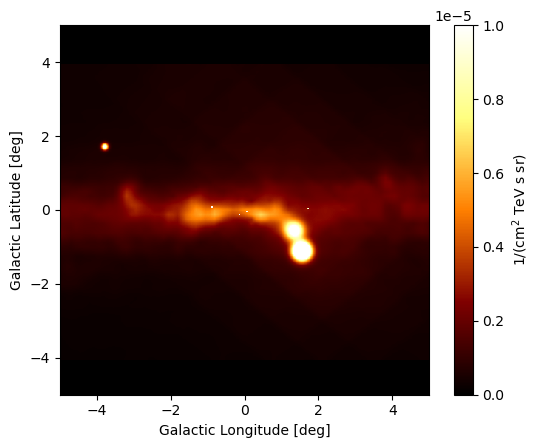

In [533]:
from matplotlib.colors import LogNorm


fermiplotmap = fermievaluated.value
combinedplotmap = fermiplotmap + fullhessdataset



fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0), cmap='afmhot', vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()